# Backtest Evaluation – Baseline Model with Costs & Sizing (v1)

This notebook evaluates the baseline backtest that includes:
- Linear regression predictions
- Fractional position sizing
- Fixed transaction costs (5 bps per position change)

The goal is to:
- Visualize equity curves
- Inspect turnover and exposure
- Understand why returns look the way they do

Input:
- data/curated/features_daily.parquet


In [ ]:
# Standard data science imports for table manipulation, numeric ops, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simple linear model used as the baseline predictor
from sklearn.linear_model import LinearRegression


In [ ]:
# Load the features produced by the pipeline. The notebook assumes
# the file contains columns like date, symbol, ret_1d, rvol_10, y_ret_1d.
df = pd.read_parquet("../data/curated/features_daily.parquet")
# Ensure deterministic ordering by symbol and date for downstream group ops
df = df.sort_values(["symbol", "date"]).reset_index(drop=True)

# Quick sanity checks to see the dataset size and a sample of rows
print(df.shape)
df.head()


(8229, 11)


,date,adj close,close,high,low,open,volume,symbol,ret_1d,rvol_10,y_ret_1d
0,2015-01-16,23.497101,26.497499,26.895000,26.299999,26.757500,314053200,AAPL,-0.007800,0.329180,0.025431
1,2015-01-20,24.102325,27.180000,27.242500,26.625000,26.959999,199599600,AAPL,0.025431,0.323760,0.007605
2,2015-01-21,24.286325,27.387501,27.764999,27.067499,27.237499,194303600,AAPL,0.007605,0.324523,0.025683
3,2015-01-22,24.918148,28.100000,28.117500,27.430000,27.565001,215185600,AAPL,0.025683,0.340529,0.005147
4,2015-01-23,25.046728,28.245001,28.437500,27.882500,28.075001,185859200,AAPL,0.005147,0.285719,0.001062


In [ ]:
# Validate that the minimal required columns exist in the dataframe
required = {"date", "symbol", "ret_1d", "rvol_10", "y_ret_1d"}
missing = required - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# Ensure there are no NaNs in the core columns used for modelling/backtest
assert df[["ret_1d", "rvol_10", "y_ret_1d"]].isna().sum().sum() == 0


In [ ]:
# Define features and target used by the baseline linear model
FEATURES = ["ret_1d", "rvol_10"]
TARGET = "y_ret_1d"

# Time-based split: first 80% training, last 20% test. Avoids shuffling
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:].copy()

# Fit baseline linear regression on train partition
model = LinearRegression()
model.fit(train[FEATURES], train[TARGET])

# Predict on the held-out test set; predictions represent expected next-day return
test["prediction"] = model.predict(test[FEATURES])


In [ ]:
# Convert raw predictions into fractional position sizes
# Normalize by the prediction std so sizing is scale-invariant, then clip to [0,1]
scale = test["prediction"].std()
test["position"] = (test["prediction"] / scale).clip(0.0, 1.0)

# Quick summary of predictions and resulting positions
test[["prediction", "position"]].describe()


,prediction,position
count,1646.000000,1646.000000
mean,0.000749,0.564227
std,0.001110,0.387292
min,-0.007575,0.000000
25%,0.000198,0.178480
50%,0.000693,0.624578
75%,0.001194,1.000000
max,0.011295,1.000000


In [ ]:
# Transaction cost parameters: COST_BPS is basis points per round-trip
COST_BPS = 5
COST = COST_BPS / 10_000

# Compute previous day's position per symbol to measure turnover
test["prev_position"] = test.groupby("symbol")["position"].shift(1).fillna(0.0)
# Absolute position change is the trade size that incurs costs
test["trade_size"] = (test["position"] - test["prev_position"]).abs()

# Transaction cost incurred this row (proportional to trade size)
test["transaction_cost"] = test["trade_size"] * COST

# Gross return before costs: position * realized next-day return
test["gross_ret"] = test["position"] * test["y_ret_1d"]
# Net return after subtracting transaction costs
test["net_ret"] = test["gross_ret"] - test["transaction_cost"]


In [ ]:
# Aggregate per-day portfolio return by averaging across symbols
daily = (
    test.groupby("date", as_index=False)["net_ret"]
    .mean()
    .rename(columns={"net_ret": "portfolio_ret"})
)

# Compute cumulative log return and convert to equity curve (starts at 1)
daily["cum_log_ret"] = daily["portfolio_ret"].cumsum()
daily["equity"] = np.exp(daily["cum_log_ret"])

daily.head()


,date,portfolio_ret,cum_log_ret,equity
0,2019-05-29,0.002227,0.002227,1.002230
1,2019-05-30,-0.006813,-0.004585,0.995425
2,2019-05-31,-0.002805,-0.007390,0.992638
3,2019-06-03,0.019087,0.011697,1.011766
4,2019-06-04,-0.000446,0.011252,1.011315


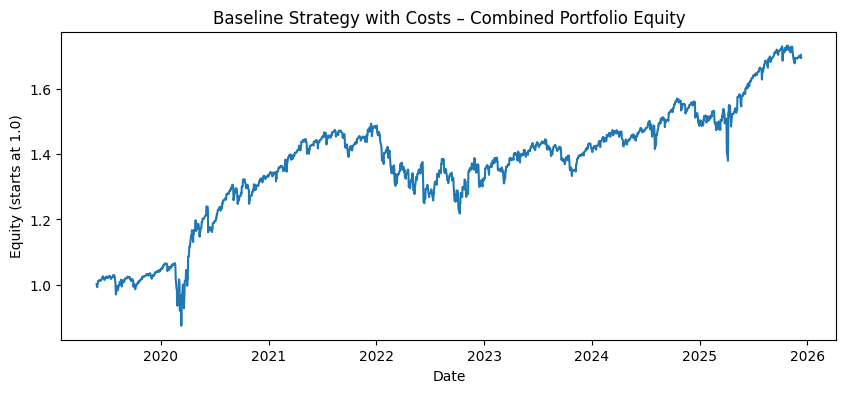

In [ ]:
# Plot the combined portfolio equity curve over time
plt.figure(figsize=(10, 4))
plt.plot(daily["date"], daily["equity"])
plt.title("Baseline Strategy with Costs – Combined Portfolio Equity")
plt.xlabel("Date")
plt.ylabel("Equity (starts at 1.0)")
plt.show()


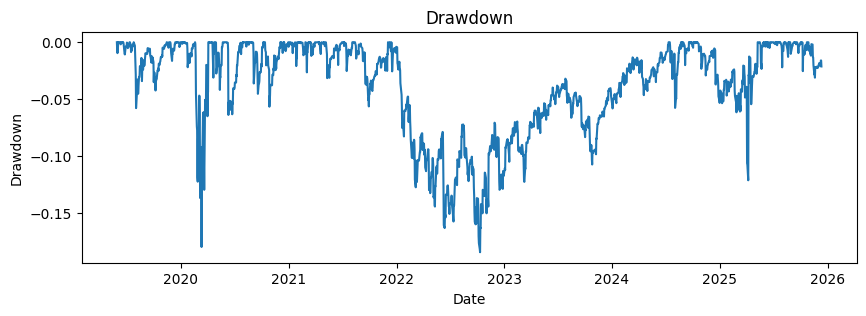

In [ ]:
# Compute drawdown from peak equity to visualize downside risk
daily["rolling_max"] = daily["equity"].cummax()
daily["drawdown"] = daily["equity"] / daily["rolling_max"] - 1

plt.figure(figsize=(10, 3))
plt.plot(daily["date"], daily["drawdown"])
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()


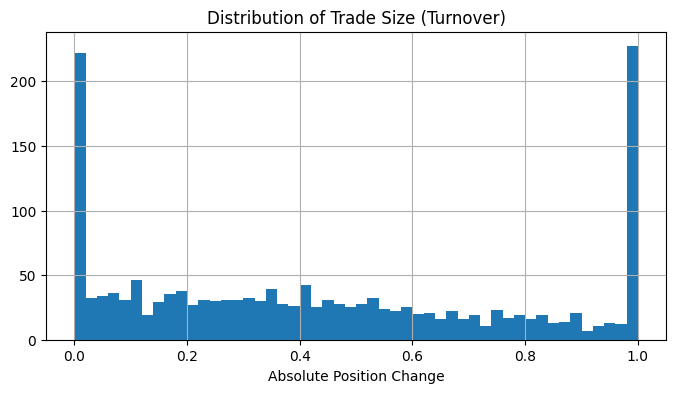

Average trade size: 0.44369555314613573


In [ ]:
# Visualize distribution of trade sizes (turnover) to inspect activity
plt.figure(figsize=(8, 4))
test["trade_size"].hist(bins=50)
plt.title("Distribution of Trade Size (Turnover)")
plt.xlabel("Absolute Position Change")
plt.show()

# Report average trade size as a simple turnover metric
print("Average trade size:", test["trade_size"].mean())


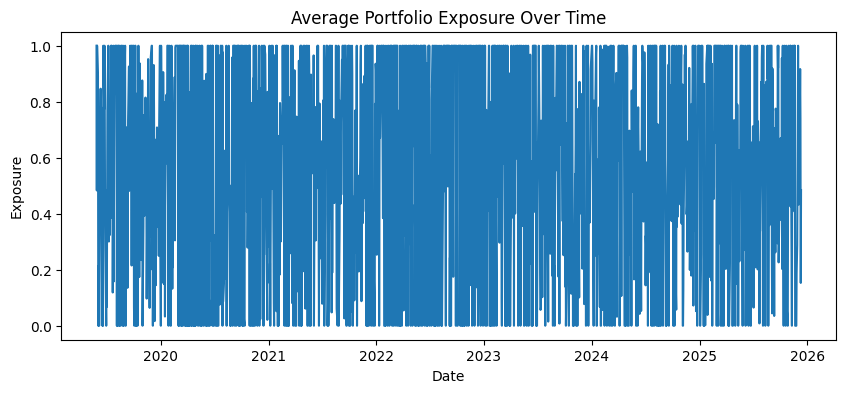

In [ ]:
# Average exposure across symbols by date to monitor crowding/exposure
daily_exposure = (
    test.groupby("date", as_index=False)["position"]
    .mean()
)

plt.figure(figsize=(10, 4))
plt.plot(daily_exposure["date"], daily_exposure["position"])
plt.title("Average Portfolio Exposure Over Time")
plt.xlabel("Date")
plt.ylabel("Exposure")
plt.show()


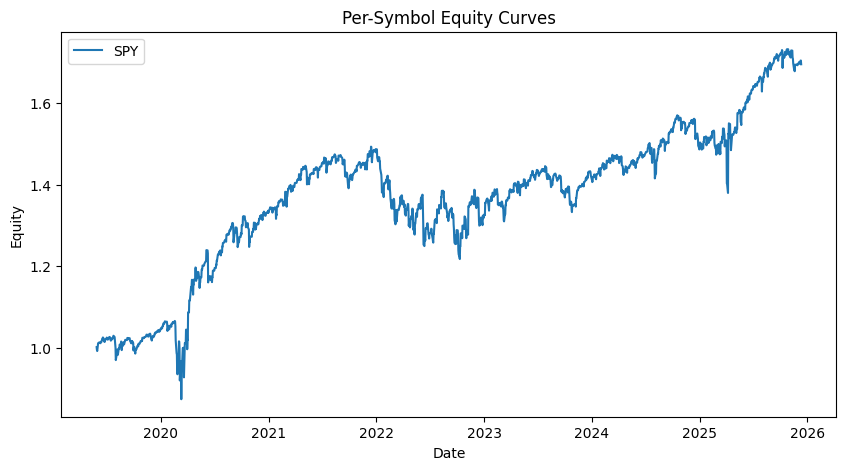

In [ ]:
# Compute per-symbol daily net return and equity to inspect individual performance
sym_daily = (
    test.groupby(["symbol", "date"], as_index=False)["net_ret"]
    .sum()
)

# Cumulative log returns per symbol converted to equity curve
sym_daily["cum_log_ret"] = sym_daily.groupby("symbol")["net_ret"].cumsum()
sym_daily["equity"] = np.exp(sym_daily["cum_log_ret"])

plt.figure(figsize=(10, 5))
# Plot equity for each symbol to identify outliers or dominant contributors
for sym in sym_daily["symbol"].unique():
    sub = sym_daily[sym_daily["symbol"] == sym]
    plt.plot(sub["date"], sub["equity"], label=sym)

plt.title("Per-Symbol Equity Curves")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.show()
